### Pytorch implementation

## Investigating the Impact of Residual Connection to Convolutional Layer on EEG Classification Performance

### Experiment Summary:

**This experiment aims to explore the influence of different convolutional layer configurations on the performance of EEG classification models. We investigate the relationship between the number of convolutional layers and the resulting accuracy.**

To conduct the experiment, we employ a sequential EEG model architecture with varying numbers of convolutional layers. Each convolutional layer utilizes a specific number of filters and kernel sizes. The models are trained and evaluated using cross-validation.

A total of 6 experiments are conducted based on the provided configurations.


Through an iterative process, we evaluate multiple configurations of convolutional layers. For each configuration, we train and evaluate the models on different folds. The training histories, including loss, accuracy, validation loss, and validation accuracy, are recorded(logged) for analysis.

The experiment involves training a significant number of models, depending on the number of convolutional layer configurations and the number of folds in cross-validation. The accuracy of each model on the validation set is monitored and logged.

The results provide insights into the impact of convolutional layer configurations on EEG classification tasks. By assessing the relationship between the number of convolutional layers and accuracy, we aim to identify the optimal configuration that yields improved performance in EEG analysis.

The experiment outcomes and accuracy results contribute to a comprehensive understanding of the influence of convolutional layer configurations on EEG classification performance. The findings can guide the design and development of more effective models for EEG-based applications.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# %mkdir /content/drive/MyDrive/ED_Experiments
%mkdir /content/drive/MyDrive/ED_Experiments/ED_CNN_E31

In [ ]:
%cd /content/drive/MyDrive/ED_Experiments/ED_CNN_E31
%ls

/content/drive/MyDrive/ED_Experiments/ED_CNN_E31


## Import libraries

In [ ]:
import sys
import os
import logging


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [ ]:
## seed
np.random.seed(2023)

### Reading CSV data

In [ ]:
raw_data = pd.read_csv('https://raw.githubusercontent.com/mamuncseru/analysis_on_epileptic_seizure_bonn_dataset/main/Epileptic%20Seizure%20Recognition.csv')
raw_data.shape

(11500, 180)

In [ ]:
raw_data

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,X22.V1.114,-22,-22,-23,-26,-36,-42,-45,-42,-45,...,15,16,12,5,-1,-18,-37,-47,-48,2
11496,X19.V1.354,-47,-11,28,77,141,211,246,240,193,...,-65,-33,-7,14,27,48,77,117,170,1
11497,X8.V1.28,14,6,-13,-16,10,26,27,-9,4,...,-65,-48,-61,-62,-67,-30,-2,-1,-8,5
11498,X10.V1.932,-40,-25,-9,-12,-2,12,7,19,22,...,121,135,148,143,116,86,68,59,55,3


In [ ]:
raw_data.values.shape

(11500, 180)

In [ ]:
data = raw_data.values # converted to an numpy array
data = data[:, 1:] # discarding the Unnamed Column
data.shape

(11500, 179)

In [ ]:
# let's see how it looks like
data

array([[135, 190, 229, ..., -83, -51, 4],
       [386, 382, 356, ..., 143, 129, 1],
       [-32, -39, -47, ..., -35, -36, 5],
       ...,
       [14, 6, -13, ..., -1, -8, 5],
       [-40, -25, -9, ..., 59, 55, 3],
       [29, 41, 57, ..., 2, 20, 4]], dtype=object)

In [ ]:
# let's see the type
type(data)

numpy.ndarray

### Classifying data categories as it mentioned in the paper

In [ ]:
df_1 = data[data[:, -1] == 1].astype(int) # seizure
df_2 = data[data[:, -1] == 2].astype(int)
df_3 = data[data[:, -1] == 3].astype(int)
df_4 = data[data[:, -1] == 4].astype(int)
df_5 = data[data[:, -1] == 5].astype(int)

# let's print the shape of each category
print(df_1.shape)
print(df_2.shape)
print(df_3.shape)
print(df_4.shape)
print(df_5.shape)

(2300, 179)
(2300, 179)
(2300, 179)
(2300, 179)
(2300, 179)


## Let's plot some random data points from every category

In [ ]:
def visualize_eeg(number_of_datapoints):
    for i in (np.random.randint(0, 2300, number_of_datapoints)):
        plt.plot(df_1[i, :], 'r-', label='df_1')
        plt.plot(df_2[i, :], 'g-', label='df_2')
        plt.plot(df_3[i, :], 'k-', label='df_3')
        plt.plot(df_4[i, :], 'b-', label='df_4')
        plt.plot(df_5[i, :], 'm-', label='df_5')
        plt.legend()
        plt.title(f'visualizing {i} th data point')
        plt.xlabel('time')
        plt.ylabel('aplitude(uV)')
        plt.show()

### Visualizing all categories in single figure

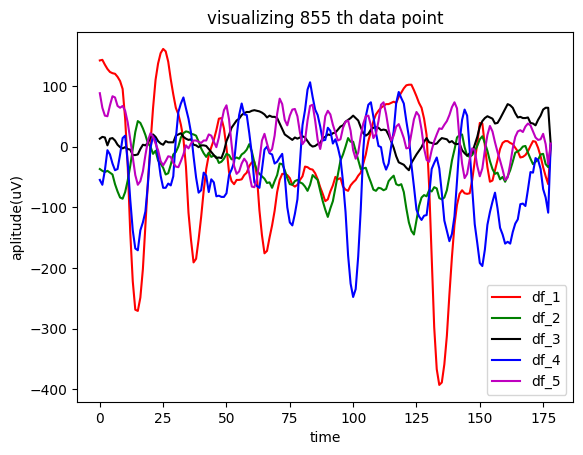

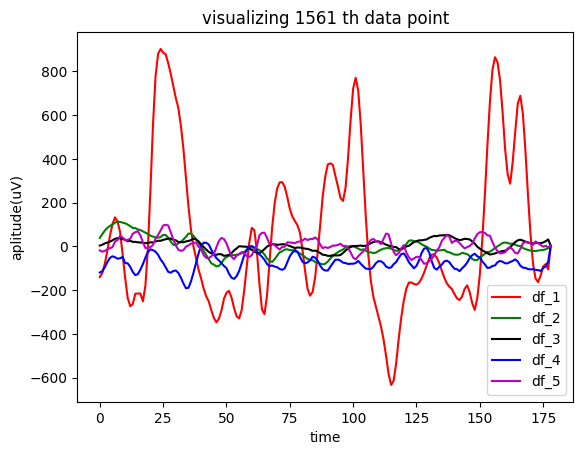

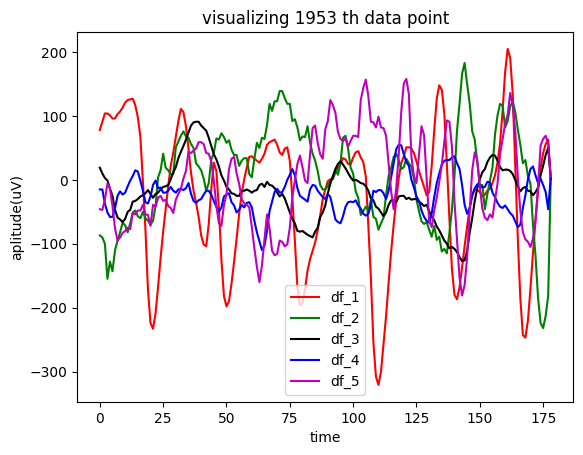

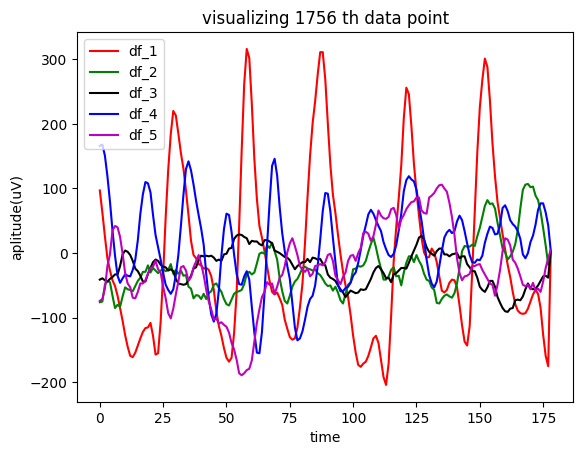

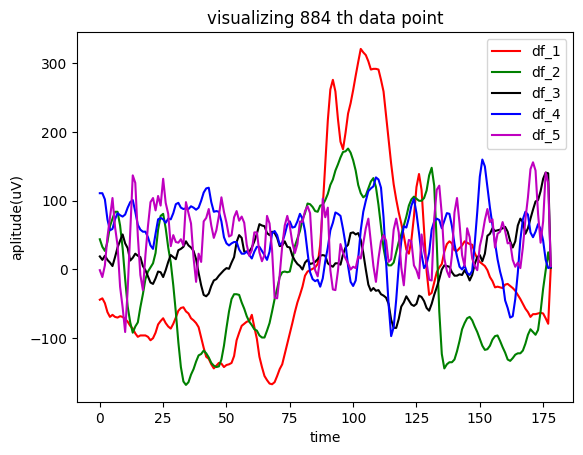

In [ ]:
### all categories
visualize_eeg(5)

## Converting data into integer and making the data into seizure and non-seizure cateogry

In [ ]:
all_data = data.copy().astype('int')

In [ ]:
all_data

array([[135, 190, 229, ..., -83, -51,   4],
       [386, 382, 356, ..., 143, 129,   1],
       [-32, -39, -47, ..., -35, -36,   5],
       ...,
       [ 14,   6, -13, ...,  -1,  -8,   5],
       [-40, -25,  -9, ...,  59,  55,   3],
       [ 29,  41,  57, ...,   2,  20,   4]])

In [ ]:
all_data[:, -1] = np.where(all_data[:, -1] != 1, 0, all_data[:, -1])
all_data

array([[135, 190, 229, ..., -83, -51,   0],
       [386, 382, 356, ..., 143, 129,   1],
       [-32, -39, -47, ..., -35, -36,   0],
       ...,
       [ 14,   6, -13, ...,  -1,  -8,   0],
       [-40, -25,  -9, ...,  59,  55,   0],
       [ 29,  41,  57, ...,   2,  20,   0]])

In [ ]:
print(len(all_data[all_data[:, -1] == 1]))
print(len(all_data[all_data[:, -1] == 0]))

2300
9200


## Plot functions

### function to plot loss curve of the
- (training and validation loss) and
- (training and validation accuracy)


In [ ]:
def plot_loss_accuracy(train_acc, val_acc, train_loss, val_loss, title):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    ax[0].plot(train_loss, 'b-')
    ax[0].plot(val_loss, 'r-')
    ax[0].legend(['train_loss', 'val_loss'])
    ax[0].set_title('Loss curve')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss %')

    ax[1].plot(train_acc, 'b-')
    ax[1].plot(val_acc, 'r-')
    ax[1].legend(['train_accuracy', 'val_accuracy'])
    ax[1].set_title('Accuracy curve')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('accuracy %')

    plt.suptitle(title)
    plt.savefig(title + '.png')

    plt.show()

In [ ]:
# Initialize StratifiedKFold with 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2023)

In [ ]:
def input_output_data(data, random_state=2023):

    X = all_data[:, :-1]
    y = all_data[:, -1]

    return X, y

X, y = input_output_data(data)

In [ ]:
def process_input(X, y, train_index, val_index):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    X_train = np.expand_dims(X_train, axis=2)
    X_val = np.expand_dims(X_val, axis=2)

    input_shape = (X_train.shape[1], 1)

    X_train = X_train.astype('float32')
    X_val = X_val.astype('float32')


    return X_train, X_val, y_train, y_val, input_shape

## Logger setup

In [ ]:
import absl.logging
import sys
import logging
absl.logging.set_verbosity(absl.logging.ERROR)
absl.logging.set_verbosity(absl.logging.INFO)

In [ ]:
def init_logger(log_file, log_level=logging.INFO, stdout=True):
    logger = logging.getLogger()
    logger.setLevel(log_level)

    formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')

    file_handler = logging.FileHandler(log_file, mode='w')
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)

    if stdout:
        console_handler = logging.StreamHandler(sys.stdout)
        console_handler.setFormatter(formatter)
        logger.addHandler(console_handler)

    return logger


## Let's experiment with the Residual Connection



In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.batchnorm1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.batchnorm2(out)

        out += identity
        out = self.relu(out)

        return out

In [ ]:
class ResidualEEGModel(nn.Module):
    def __init__(self, input_shape):
        super(ResidualEEGModel, self).__init__()
        self.conv1 = nn.Conv1d(input_shape[1], 128, kernel_size=5, padding=(1,))
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.activation1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(2, padding=(1,))

        self.residual1 = ResidualBlock(128, 128)

        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=(1,))
        self.batchnorm2 = nn.BatchNorm1d(256)
        self.activation2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool1d(2, padding=(1,))

        self.residual2 = ResidualBlock(256, 256)

        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=(1,))
        self.batchnorm3 = nn.BatchNorm1d(512)
        self.activation3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool1d(2, padding=(1,))

        self.residual3 = ResidualBlock(512, 512)

        self.conv4 = nn.Conv1d(512, 1024, kernel_size=3, padding=(1,))
        self.batchnorm4 = nn.BatchNorm1d(1024)
        self.activation4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool1d(2, padding=(1,))

        self.residual4 = ResidualBlock(1024, 1024)

        self.conv5 = nn.Conv1d(1024, 2048, kernel_size=3, padding=(1,))
        self.batchnorm5 = nn.BatchNorm1d(2048)
        self.activation5 = nn.ReLU()
        self.maxpool5 = nn.MaxPool1d(2, padding=(1,))

        self.residual5 = ResidualBlock(2048, 2048)

        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(14336, 128)
        self.activation6 = nn.ReLU()
        self.dense2 = nn.Linear(128, 32)
        self.activation7 = nn.ReLU()
        self.output = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.activation1(x)
        x = self.maxpool1(x)

        x = self.residual1(x)

        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.activation2(x)
        x = self.maxpool2(x)

        x = self.residual2(x)

        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.activation3(x)
        x = self.maxpool3(x)

        x = self.residual3(x)

        x = self.conv4(x)
        x = self.batchnorm4(x)
        x = self.activation4(x)
        x = self.maxpool4(x)

        x = self.residual4(x)

        x = self.conv5(x)
        x = self.batchnorm5(x)
        x = self.activation5(x)
        x = self.maxpool5(x)

        x = self.residual5(x)

        x = self.flatten(x)
        x = self.dense1(x)
        x = self.activation6(x)
        x = self.dense2(x)
        x = self.activation7(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x


In [ ]:
# Create an instance of the model
input_shape = (32, 1, 178)  # Provide the appropriate input shape
model = ResidualEEGModel(input_shape)

# Forward pass
inputs = torch.randn(input_shape)
outputs = model(inputs)

# Print the output shape
print(outputs.shape)

torch.Size([32, 1])




---- fold = 1 ------



Epoch 100: 100%|██████████| 288/288 [00:16<00:00, 17.52batch/s, Loss=3.51e-7]


model_Fold = 1 accuracy: 0.9921739130434782


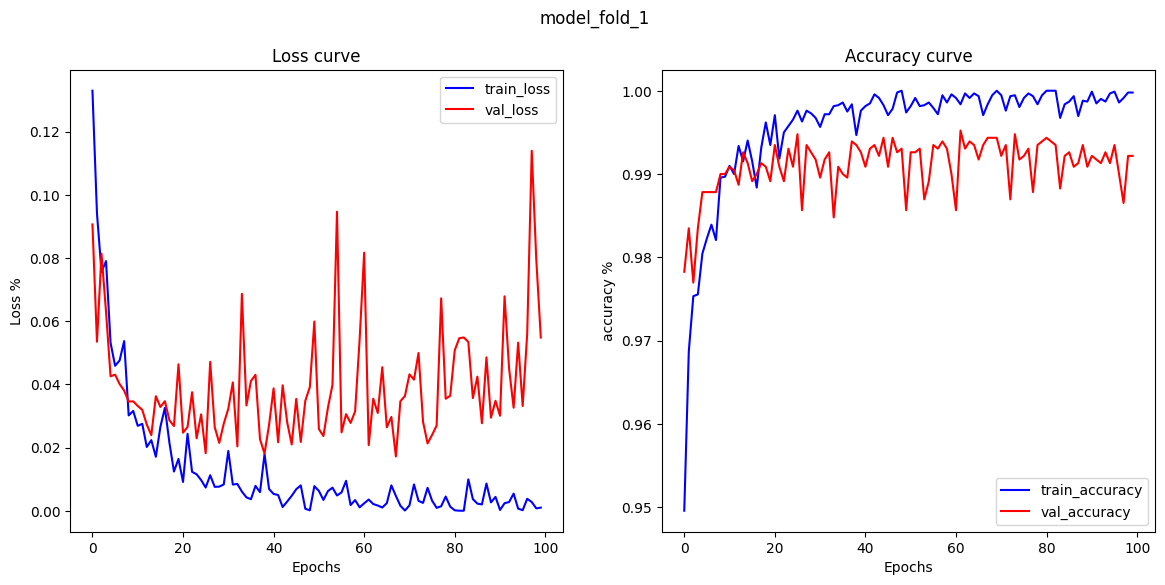



---- fold = 2 ------



Epoch 100: 100%|██████████| 288/288 [00:16<00:00, 17.41batch/s, Loss=2.13e-7]


model_Fold = 2 accuracy: 0.9947826086956522


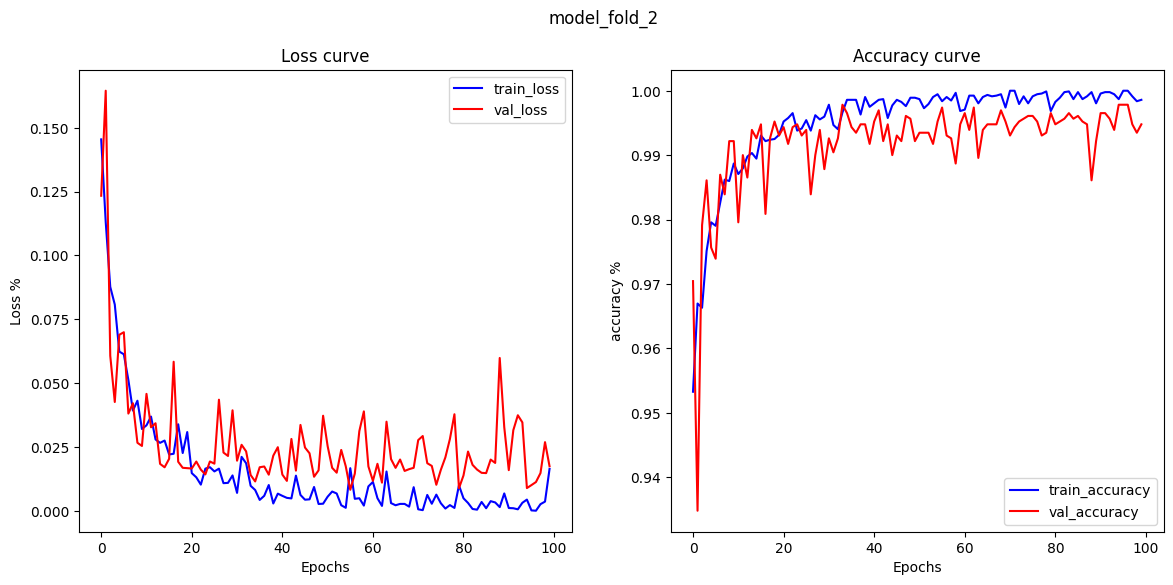



---- fold = 3 ------



Epoch 100: 100%|██████████| 288/288 [00:16<00:00, 17.39batch/s, Loss=0.00982]


model_Fold = 3 accuracy: 0.9960869565217392


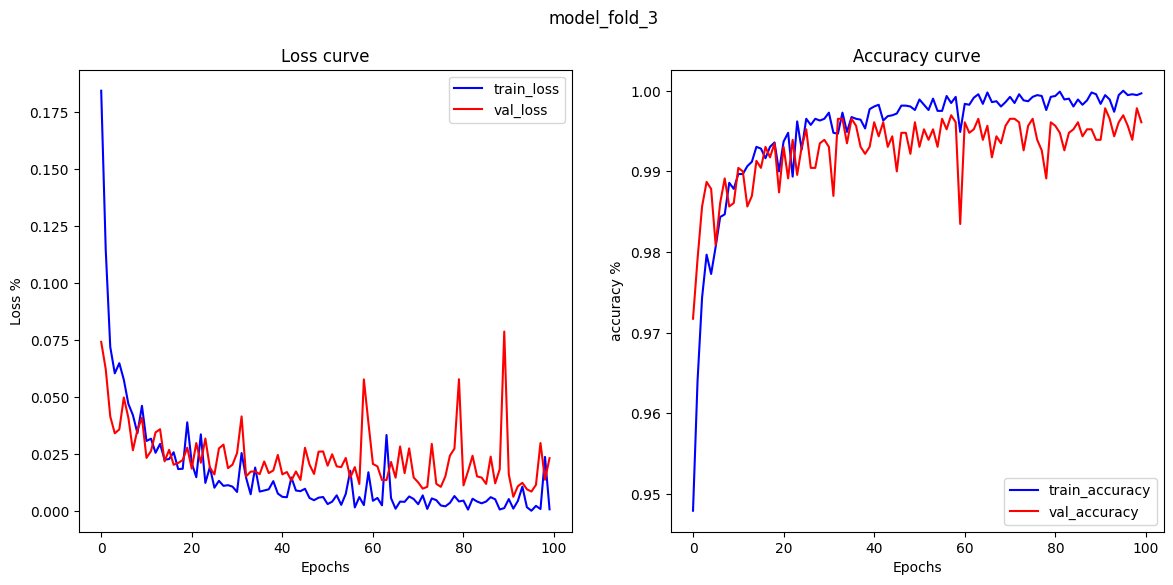



---- fold = 4 ------



Epoch 100: 100%|██████████| 288/288 [00:16<00:00, 17.43batch/s, Loss=0.00101]


model_Fold = 4 accuracy: 0.9943478260869565


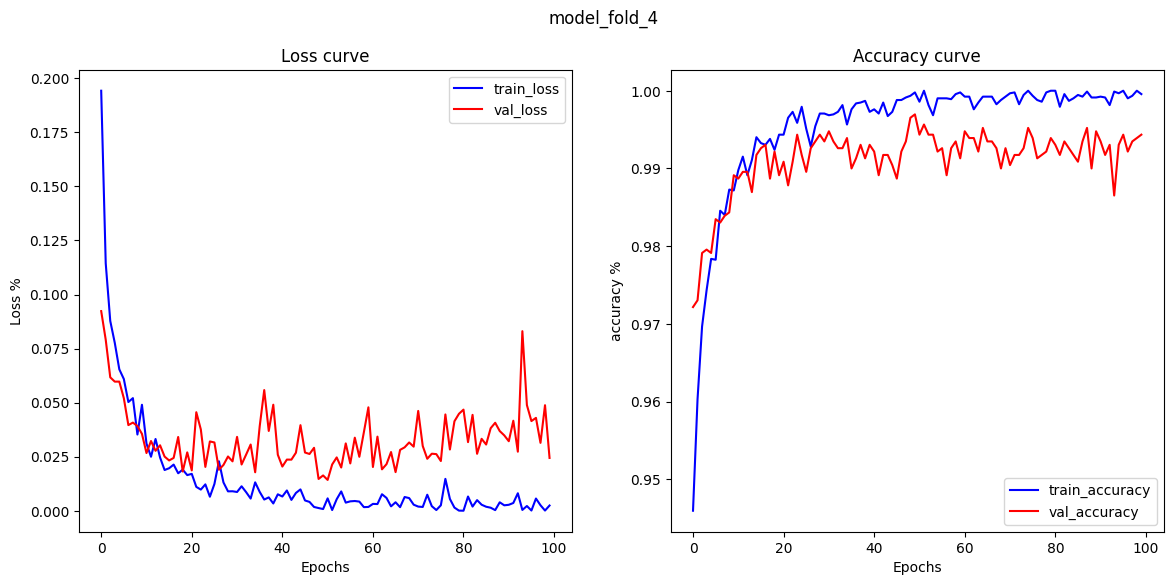



---- fold = 5 ------



Epoch 100: 100%|██████████| 288/288 [00:16<00:00, 17.51batch/s, Loss=4.4e-8]


model_Fold = 5 accuracy: 0.9943478260869565


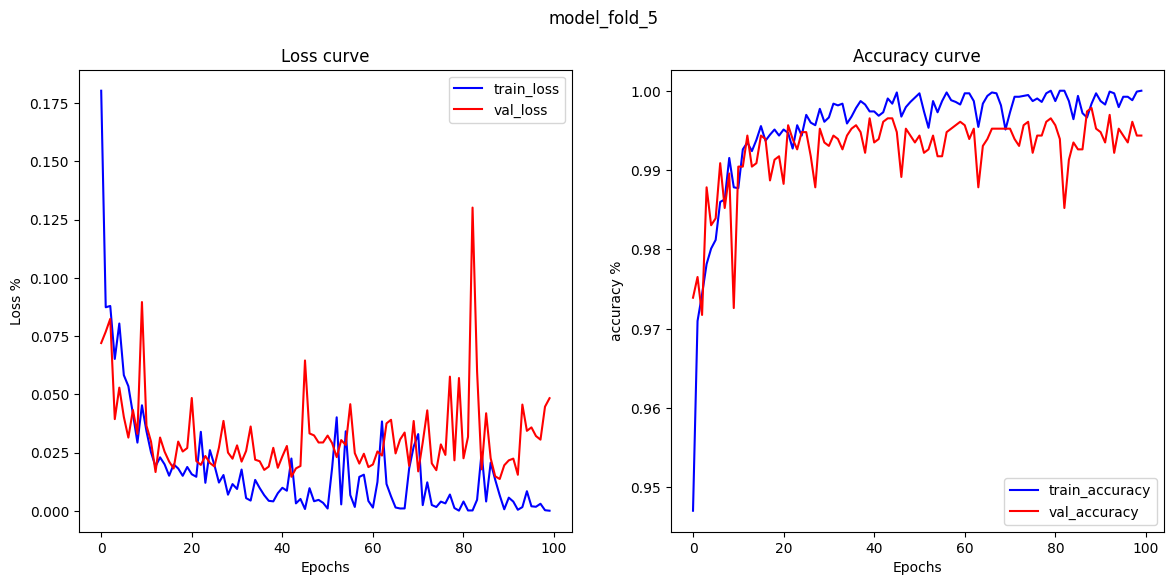

Mean Accuracy: 0.9943478260869565


In [ ]:

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Perform cross-validation
fold_accuracy = []
fold = 1

best_val_acc = 0.0
best_model = None

for train_index, val_index in skf.split(X, y):
    X_train, X_val, y_train, y_val, input_shape = process_input(X, y, train_index, val_index)

    log_file = f"model_fold_{fold}.log"
    model_name = f"model_fold_{fold}.pt"

    # Clear existing log handlers and close log files
    root_logger = logging.getLogger()
    for handler in root_logger.handlers:
        handler.close()
    root_logger.handlers.clear()

    # Create a separate log file for each model
    logger = init_logger(log_file, stdout=False)

    # Create the PyTorch model
    model = ResidualEEGModel(input_shape).to(device)

    # Define the loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters())

    # Convert data to PyTorch tensors and create datasets
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    # Create data loaders
    batch_size = 32  # Adjust the batch size as needed
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    logger.info(f"\n\n---- fold = {fold} -------\n")
    print(f"\n\n---- fold = {fold} ------\n")

    train_acc = []
    val_acc = []
    train_loss = []
    val_loss = []

    # Train the model
    num_epochs = 100  # Adjust the number of epochs as needed
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        running_corrects = 0

        # Use tqdm for progress bar
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}", unit="batch") as pbar:
            # Iterate over the batches of the training set
            for inputs, targets in train_loader:
                inputs = torch.permute(inputs, (0,2,1)).to(device)
                targets = targets.unsqueeze(1).to(device)
                optimizer.zero_grad()  # Zero the gradients
                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, targets)  # Compute the loss
                loss.backward()  # Backward pass
                optimizer.step()  # Update the weights

                running_loss += loss.item()

                # Calculate the number of correct predictions
                predicted_labels = (outputs >= 0.5).float()
                running_corrects += torch.sum(predicted_labels == targets).item()

                pbar.update(1)
                pbar.set_postfix({"Loss": loss.item()})

        # Calculate the average loss and accuracy for the epoch
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = running_corrects / len(train_dataset)

        train_acc.append(epoch_acc)
        train_loss.append(epoch_loss)

        # Log loss and accuracy for the epoch
        logger.info(f"Epoch {epoch+1} - Loss: {epoch_loss} - Accuracy: {epoch_acc}")

        # Evaluate the model on the validation set
        model.eval()
        val_loss_epoch = 0.0
        val_total = 0
        val_correct = 0

        # Disable gradient computation and update
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = torch.permute(inputs, (0,2,1)).to(device)
                targets = targets.unsqueeze(1).to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss_epoch += loss.item()

                # Calculate the accuracy
                predicted_labels = (outputs >= 0.5).float()
                val_total += targets.size(0)
                val_correct += (predicted_labels == targets).sum().item()

        # Calculate the average loss and accuracy
        val_loss_epoch /= len(val_loader)
        val_acc_epoch = val_correct / val_total

        val_acc.append(val_acc_epoch)
        val_loss.append(val_loss_epoch)

        # Log loss and accuracy for the epoch
        logger.info(f"Epoch {epoch+1} - Validation Loss: {val_loss_epoch} - Validation Accuracy: {val_acc_epoch}")

        # Save the best model
        if val_acc_epoch > best_val_acc:
            best_val_acc = val_acc_epoch
            best_model = model.state_dict()

    # Log fold accuracy
    logger.info(f"model_Fold = {fold} accuracy: {val_acc_epoch}")
    print(f"model_Fold = {fold} accuracy: {val_acc_epoch}")

    # Append fold accuracy to the list
    fold_accuracy.append(val_acc_epoch)

    plot_loss_accuracy(train_acc, val_acc, train_loss, val_loss, f"model_fold_{fold}")

    fold += 1
    # Save the best model to a file
    torch.save(best_model, model_name)

mean_accuracy = np.mean(fold_accuracy)
print("Mean Accuracy:", mean_accuracy)
